In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import correlate

Step 1: Load data from file

In [131]:
data = pd.read_csv('ecg_data_nan.csv')

Step 2: Check and handle missing values

In [133]:
bad_row_index = []
for i in range(0, data.shape[0]):
    if np.any(np.isnan(data.iloc[i])):
        bad_row_index.append(i)

data = data.drop(bad_row_index)

In [134]:
fs = 1000 # sampling rate (Hz)
Ts = 1/fs # sampling interval (seconds)
N = data.shape[0] # total number of data points in the ECG signal
Duration = N/fs 
t = np.linspace(0,Duration-Ts,N)
x = np.zeros(15000)

Step 3: Plot the signal

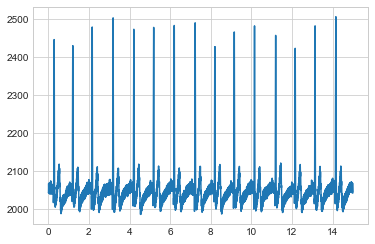

In [135]:
fig, ax = plt.subplots()
ax.plot(t, data, '-')

In [136]:
x=data['Amp'].values

In [137]:
def peak_detection(x):
    h1 = [-1, 1, 0]
    h2 = [0, 1, -1]
    y = correlate(x, h1, mode='nearest')
    z = correlate(x, h2, mode='nearest')
    IndexArray1 = np.where(y>0)
    IndexArray2 = np.where(z>0)
    PeakIndexArray = np.intersect1d(IndexArray1, IndexArray2)
    return PeakIndexArray

Step 4: Smooth the signal using cross-correlation with Gaussian Kernel

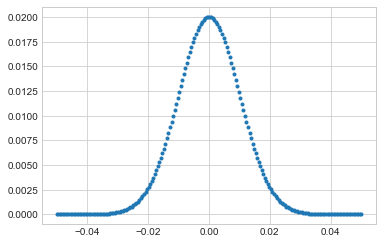

In [138]:
tg = np.linspace(-0.05, 0.05, 200)
sigma=0.01
GaussianKernel = np.exp(-tg**2/(2*sigma**2))
GaussianKernel /= GaussianKernel.sum()
fig, ax = plt.subplots()
ax.plot(tg, GaussianKernel, '.')

In [139]:
data_smooth = correlate(x, GaussianKernel, mode='nearest')

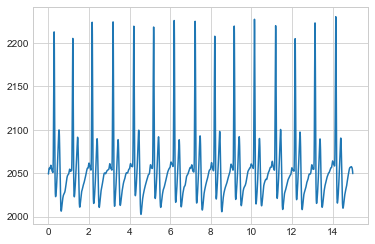

In [140]:
fig, ax = plt.subplots()
ax.plot(t, data_smooth, '-')

Step 5: Peak detection

In [141]:
PeakIndexArray = peak_detection(data_smooth)

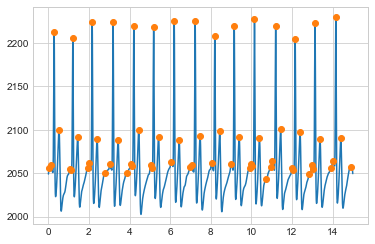

In [142]:
fig, ax=plt.subplots()
ax.plot(t, data_smooth, '-')
ax.plot(t[PeakIndexArray], data_smooth[PeakIndexArray], 'o')

Step 6: Peak selection and visualization

In [143]:
threshold = 2150
PeakIndexThreshold = []
for i in range(0, len(PeakIndexArray)):
    if data_smooth[PeakIndexArray[i]] > threshold:
        PeakIndexThreshold.append(PeakIndexArray[i])
        
PeakIndexThreshold = np.array(PeakIndexThreshold)

Text(0.5, 0, 'Time [s]')

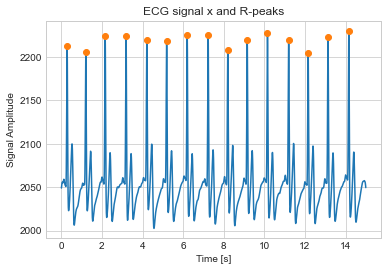

In [144]:
fig, ax=plt.subplots()
ax.plot(t, data_smooth, '-')
ax.plot(t[PeakIndexThreshold], data_smooth[PeakIndexThreshold], 'o')
ax.set_title('ECG signal x and R-peaks')
ax.set_ylabel('Signal Amplitude')
ax.set_xlabel('Time [s]')

Step 7: Calculate heart rate per minute based on the R-peaks

In [146]:
def heart_rate(t1, t2):
    return 60 / (t2-t1)

In [147]:
Rate = []
Rate.append(heart_rate(t[PeakIndexThreshold[0]],t[PeakIndexThreshold[1]]))
for i in range(1, len(PeakIndexThreshold)):
    Rate.append(heart_rate(t[PeakIndexThreshold[i-1]]
                           , t[PeakIndexThreshold[i]]))
Rate = np.array(Rate)

(0.0, 100.0)

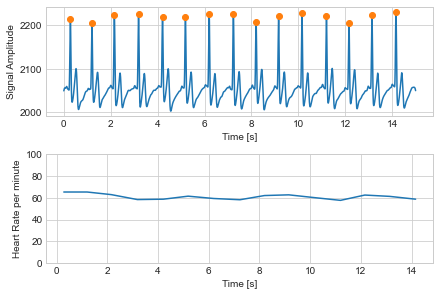

In [148]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)
ax[0].plot(t, data_smooth, '-')
ax[0].plot(t[PeakIndexThreshold], data_smooth[PeakIndexThreshold], 'o')
ax[0].set_ylabel('Signal Amplitude')
ax[0].set_xlabel('Time [s]')
ax[1].plot(t[PeakIndexThreshold], Rate, '-')
ax[1].set_ylabel('Heart Rate per minute')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylim(0, 100, 20)

Step 8: Create a new dataframe and save it to a csv file

In [149]:
df = pd.DataFrame(data_smooth[PeakIndexThreshold], 
                  columns=['R-peak'])
df['heart-rate'] = Rate

In [130]:
df

,R-peak,heart-rate
0,2212.810110,65.217391
1,2205.317728,65.217391
2,2223.921938,62.827225
3,2224.331165,58.309038
4,2219.369268,58.651026
5,2218.421959,61.412487
6,2225.924000,59.288538
7,2225.036259,58.139535
8,2207.822291,61.983471
9,2219.526843,62.630480


In [151]:
df.to_csv('assignment2_df.csv')